# 0. import necessary libraries

In [12]:
import requests
from io import BytesIO
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
url = "https://www.zooroyal.de/magazin/wp-content/uploads/2024/02/432506_PantherMedia_10058342_leopardschildkrte-760x533.jpg"

In [8]:
response = requests.get(url)

In [13]:
img = np.array(Image.open(BytesIO(response.content)))

(-0.5, 759.5, 532.5, -0.5)

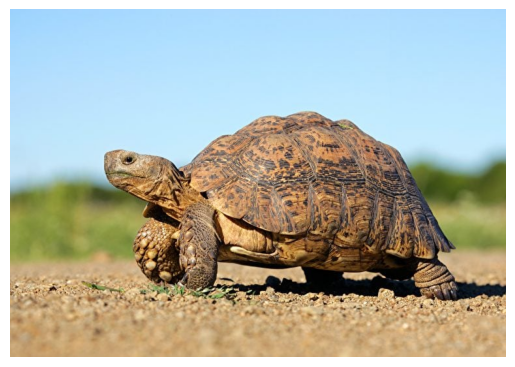

In [14]:
plt.imshow(img)
plt.axis('off')

In [15]:
img.shape

(533, 760, 3)

In [16]:
img_flat = img.reshape(-1, 3)
img_flat[:5,:]

array([[155, 209, 253],
       [155, 209, 253],
       [155, 209, 253],
       [155, 209, 253],
       [156, 210, 254]], dtype=uint8)

In [17]:
img_flat.shape

(405080, 3)

# KMeans

In [18]:
from sklearn.cluster import KMeans


In [19]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(img_flat)

In [20]:
img_flat2 = img_flat.copy()

# loops for each cluster center
for i in np.unique(kmeans.labels_):
    img_flat2[kmeans.labels_==i,:] = kmeans.cluster_centers_[i]

In [21]:
kmeans.cluster_centers_

array([[196.66487168, 163.67483318, 117.33225086],
       [183.15548394, 226.14821896, 252.72942954],
       [ 80.21929014,  63.54356335,  34.91507235],
       [164.46837236, 131.15432601,  95.63752524],
       [219.22161703, 186.29262443, 141.06988307],
       [ 24.00157638,  14.06415401,   8.99144932],
       [120.47902591,  99.05416049,  65.76836362],
       [141.77331987, 149.7264826 ,  72.46947017]])

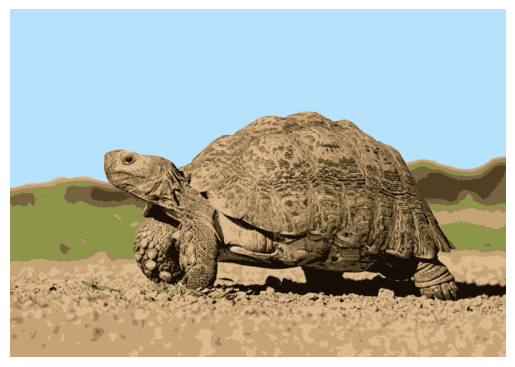

In [22]:
img2 = img_flat2.reshape(img.shape)
plt.imshow(img2)
plt.axis('off');

In [23]:
def image_cluster(img, k):
    img_flat = img.reshape(img.shape[0]*img.shape[1],3)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(img_flat)
    img_flat2 = img_flat.copy()

    # loops for each cluster center
    for i in np.unique(kmeans.labels_):
        img_flat2[kmeans.labels_==i,:] = kmeans.cluster_centers_[i]
        
    img2 = img_flat2.reshape(img.shape)
    return img2, kmeans.inertia_

In [24]:
k_vals = list(range(2,21,2))
img_list = []
inertia = []
for k in k_vals:
#    print(k)
    img2, ine = image_cluster(img,k)
    img_list.append(img2)
    inertia.append(ine)  

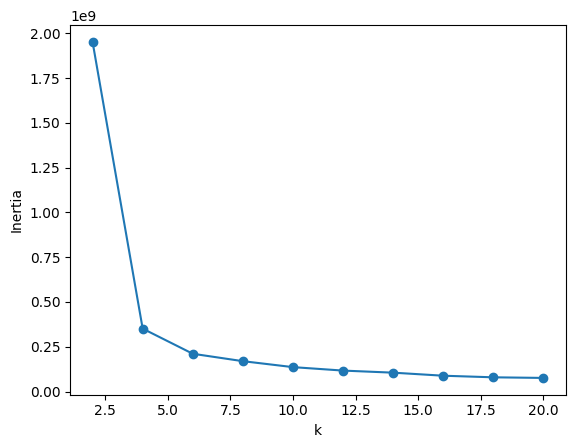

In [25]:
# Plot to find optimal number of clusters
plt.plot(k_vals,inertia)
plt.scatter(k_vals,inertia)
plt.xlabel('k')
plt.ylabel('Inertia');

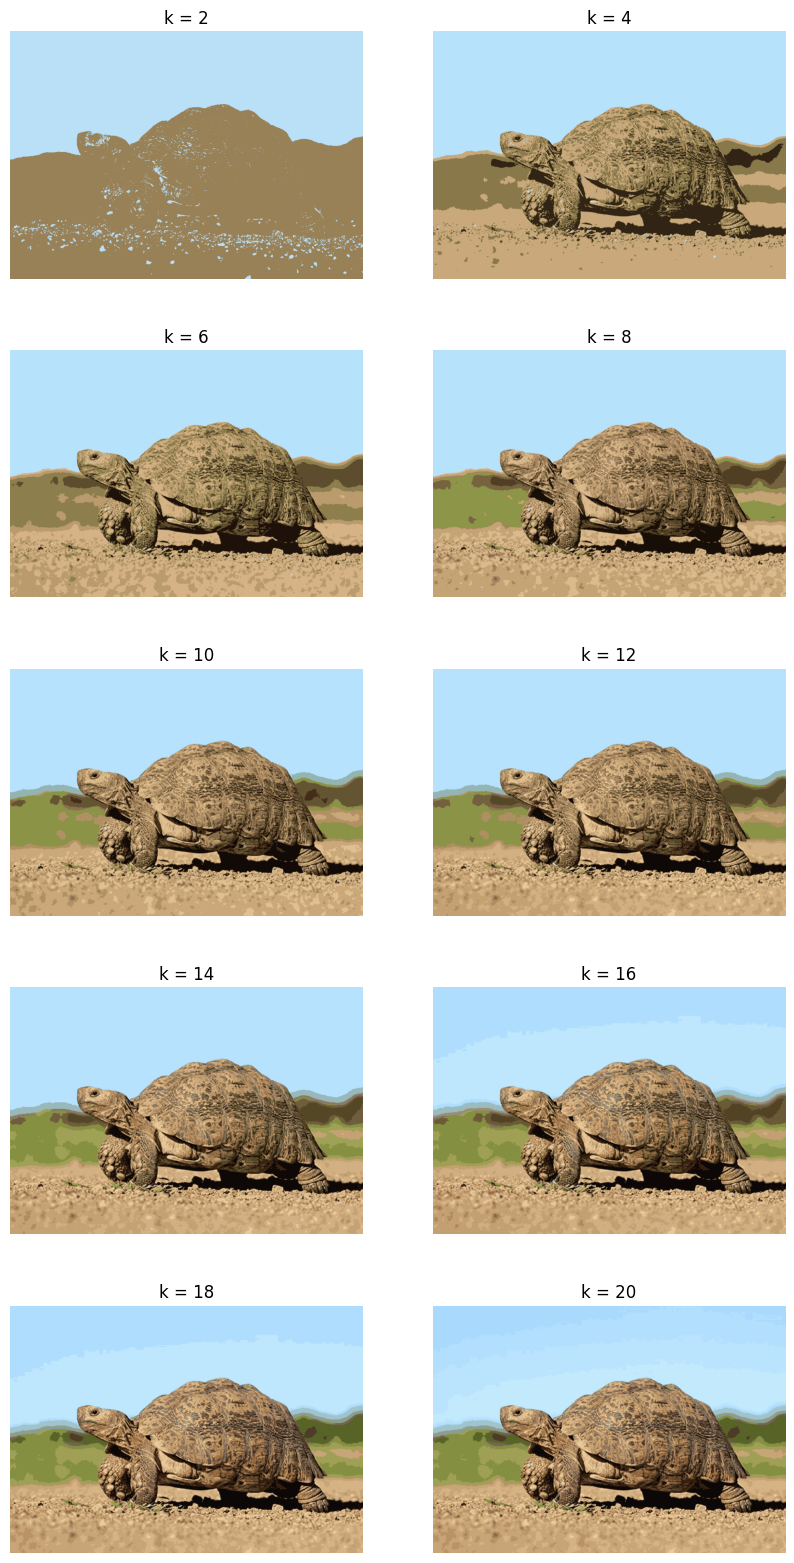

In [26]:
plt.figure(figsize=[10,20])
for i in range(len(k_vals)):
    plt.subplot(5,2,i+1)
    plt.imshow(img_list[i])
    plt.title('k = '+ str(k_vals[i]))
    plt.axis('off');

# GMM

In [28]:
from sklearn.mixture import GaussianMixture


In [29]:
# X = img.reshape(-1, 3)
X = img_flat
# The number of components; you can change this to a positive integer of your choice!:
n = 2
gmm = GaussianMixture(n_components=n, covariance_type='tied')
gmm.fit(X)
labels = gmm.predict(X) # num of pixels x 1

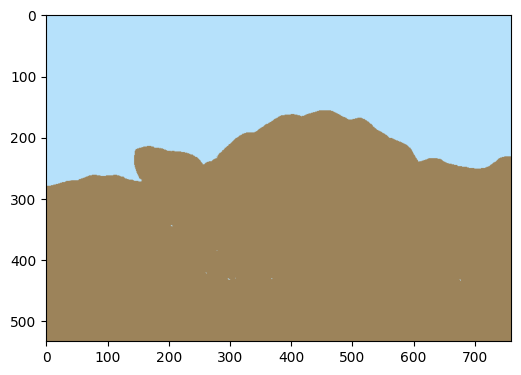

In [30]:
seg = np.zeros(X.shape) # num of pixels x 3

for label in range(n):
    seg[labels == label] = gmm.means_[label]
seg = seg.reshape(img.shape).astype(np.uint8)

plt.figure(figsize=(6,6))
plt.imshow(seg)

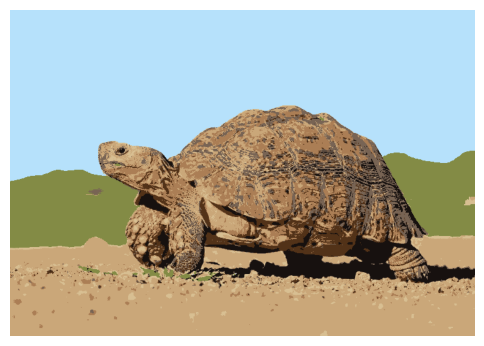

In [91]:
n = 8
gmm = GaussianMixture(n_components=n, covariance_type='tied')
gmm.fit(X)
labels = gmm.predict(X) # num of pixels x 1
seg = np.zeros(X.shape) # num of pixels x 3

for label in range(n):
    seg[labels == label] = gmm.means_[label]
seg = seg.reshape(img.shape).astype(np.uint8)
#cv2.imwrite(f'gauss-cat-{n}.jpeg', seg)

plt.figure(figsize=(6,6))
plt.imshow(seg)
plt.axis('off')
plt.show()

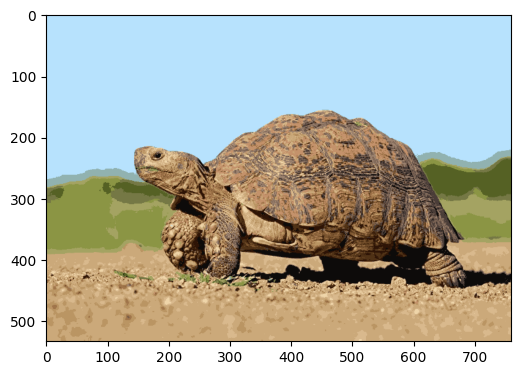

In [47]:
n = 20
gmm = GaussianMixture(n_components=n, covariance_type='tied')
gmm.fit(X)
labels = gmm.predict(X) # num of pixels x 1
seg = np.zeros(X.shape) # num of pixels x 3

for label in range(n):
    seg[labels == label] = gmm.means_[label]
seg = seg.reshape(img.shape).astype(np.uint8)
#cv2.imwrite(f'gauss-cat-{n}.jpeg', seg)

plt.figure(figsize=(6,6))
plt.imshow(seg)
plt.show()

In [58]:
def image_cluster_gmm(img, n):
    img_flat = img.reshape(img.shape[0]*img.shape[1],3)
    # n = 20
    gmm = GaussianMixture(n_components=n, covariance_type='tied')
    gmm.fit(img_flat)
    labels = gmm.predict(img_flat) # num of pixels x 1
    seg = np.zeros(img_flat.shape) # num of pixels x 3

    for label in range(n):
        seg[labels == label] = gmm.means_[label]
    seg = seg.reshape(img.shape).astype(np.uint8)
        
    # img2 = img_flat2.reshape(img.shape)
    return seg

In [59]:
n_vals = list(range(2,21,2))

In [61]:
img_list_gmm = []
# inertia = []
for n in n_vals:
#    print(k)
    img2 = image_cluster_gmm(img,n)
    img_list_gmm.append(img2)
    # inertia.append(ine)  

In [60]:
n_vals

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

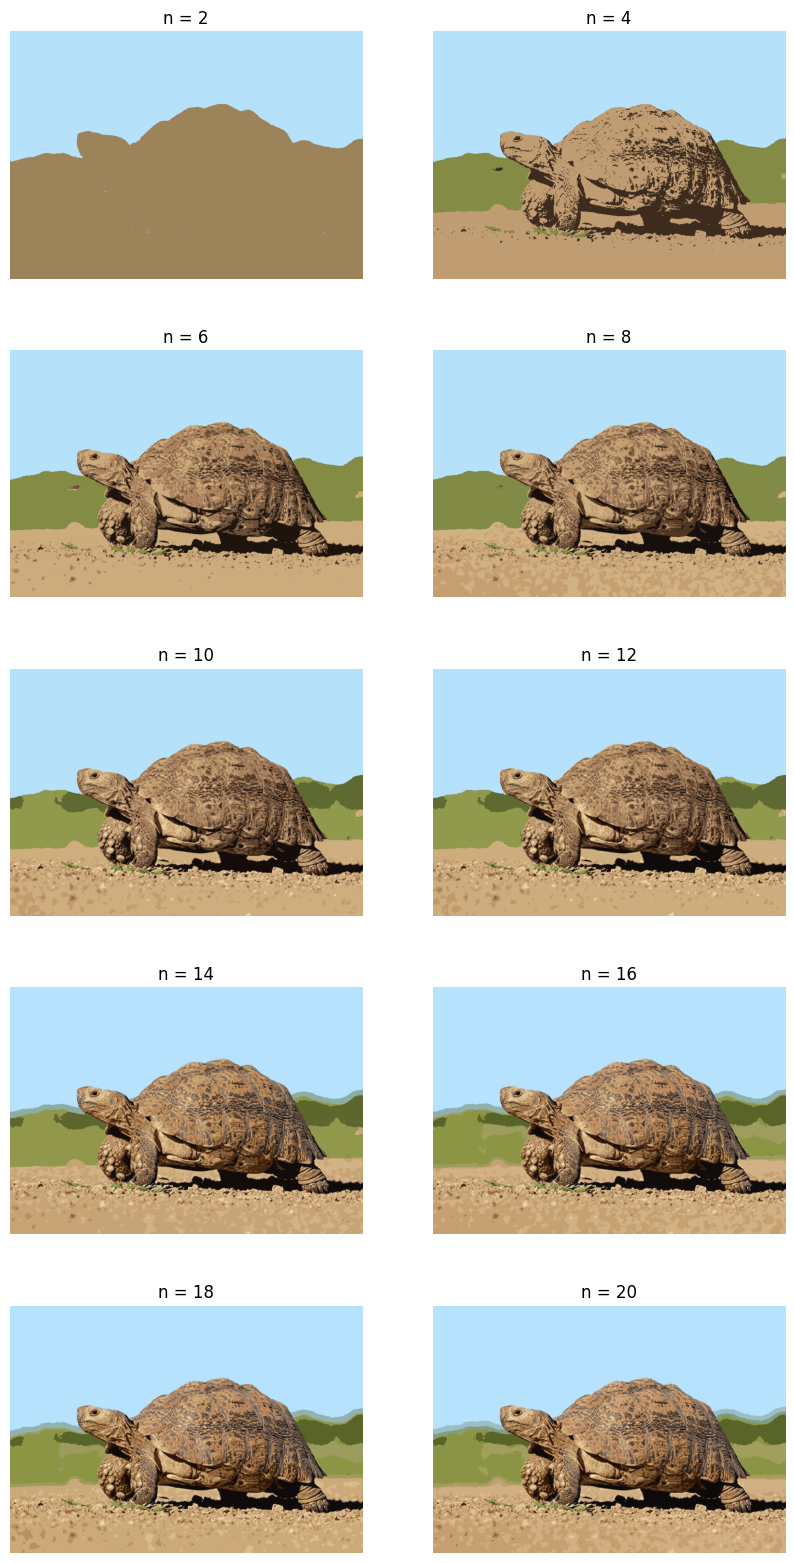

In [62]:
plt.figure(figsize=[10,20])
for i in range(len(n_vals)):
    plt.subplot(5,2,i+1)
    plt.imshow(img_list_gmm[i])
    plt.title('n = '+ str(n_vals[i]))
    plt.axis('off');

# Mean Shift Clustering

In [33]:
from sklearn.cluster import MeanShift, estimate_bandwidth


In [66]:
X = np.float32(X)

In [67]:
bandwidth = estimate_bandwidth(X, quantile=.06, n_samples=3000)
bandwidth 

20.929067278600787

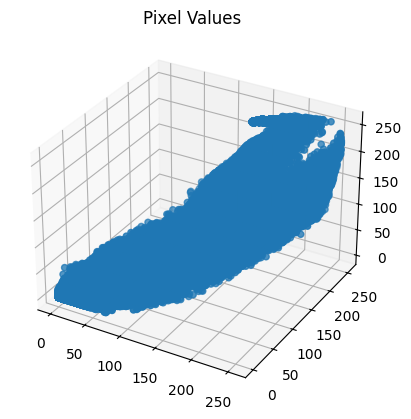

In [68]:
ax = plt.axes(projection ="3d")
ax.scatter3D(img[:,:,0],img[:,:,1],img[:,:,2])
ax.set_title('Pixel Values ')
plt.show()

In [69]:
ms = MeanShift(bandwidth=bandwidth,bin_seeding=True)
ms.fit(X)

MeanShift(bandwidth=20.929067278600787, bin_seeding=True)

In [70]:
labeled=ms.labels_
labeled

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [71]:
clusters=ms.predict(X)
clusters

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [72]:
np.unique(labeled)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [73]:
cluster_int8=np.uint8(ms.cluster_centers_)
cluster_int8

array([[183, 227, 254],
       [204, 169, 123],
       [139, 148,  67],
       [  9,   5,   4],
       [ 89,  61,  37],
       [ 82,  94,  34],
       [116, 142, 104]], dtype=uint8)

In [87]:
ms.predict(X)

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

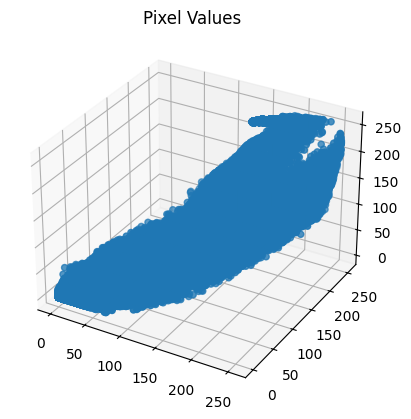

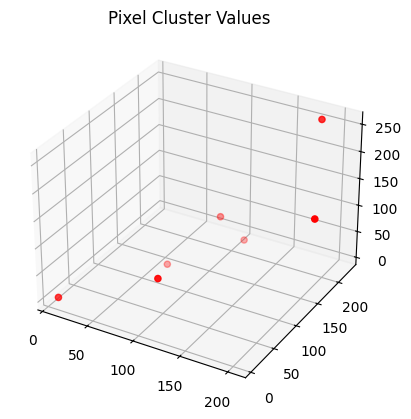

In [75]:
ax = plt.axes(projection ="3d")
ax.scatter3D(img[:,:,0],img[:,:,1],img[:,:,2])
ax.set_title('Pixel Values ')
plt.show()

ax = plt.axes(projection ="3d")
ax.set_title('Pixel Cluster Values  ')
ax.scatter3D(cluster_int8[:,0],cluster_int8[:,1],cluster_int8[:,2],color='red')
plt.show()

In [88]:
result=np.zeros(X.shape,dtype=np.uint8)

for label in np.unique(labeled):
    result[labeled==label,:]=cluster_int8[label,:]    
    

result=result.reshape(img.shape)

In [77]:
import cv2 as cv


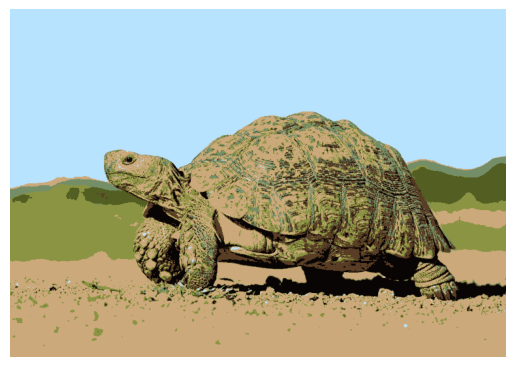

In [89]:
plt.imshow(result)
plt.axis('off')
plt.show()

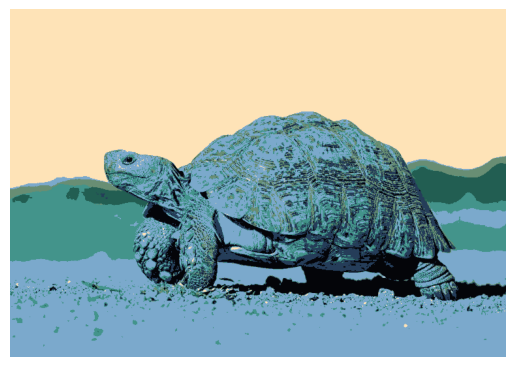

In [79]:
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



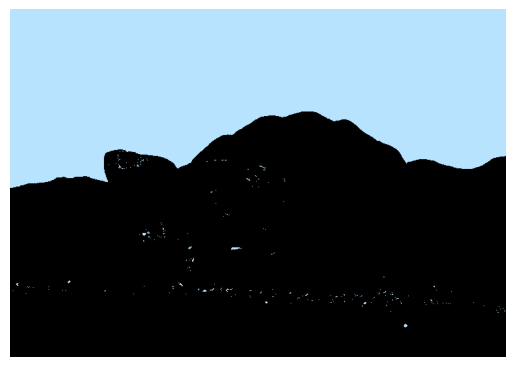

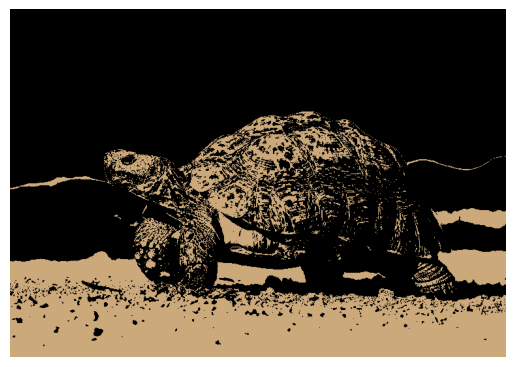

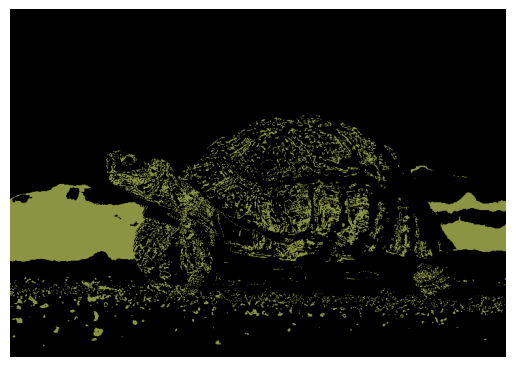

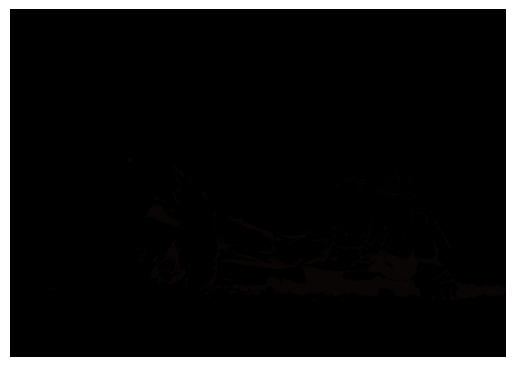

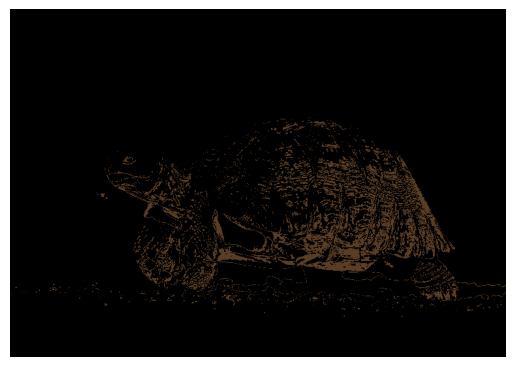

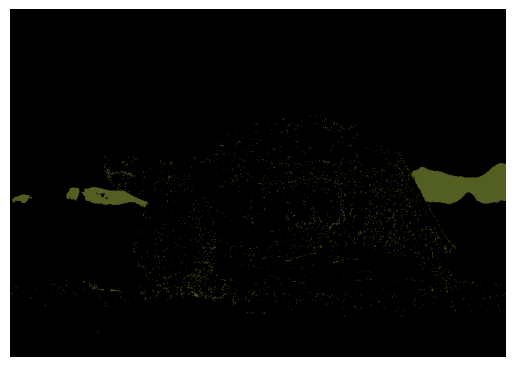

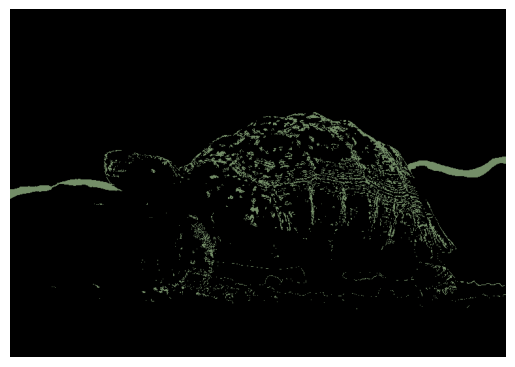

In [90]:
for label in np.unique(labeled):
    result=np.zeros(X.shape,dtype=np.uint8)
    result[labeled==label,:]=cluster_int8[label,:]  
    plt.imshow(result.reshape(img.shape))
    plt.axis('off')
    plt.savefig("meanshift_label_0" +str(label) + ".png")
    plt.show()

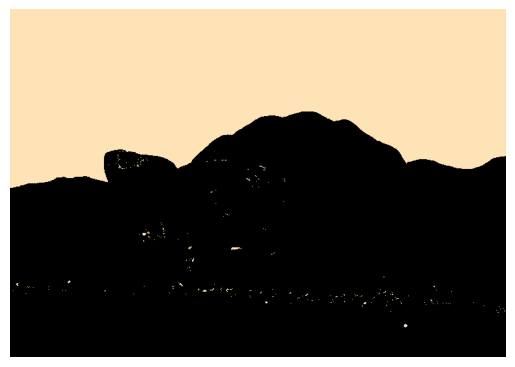

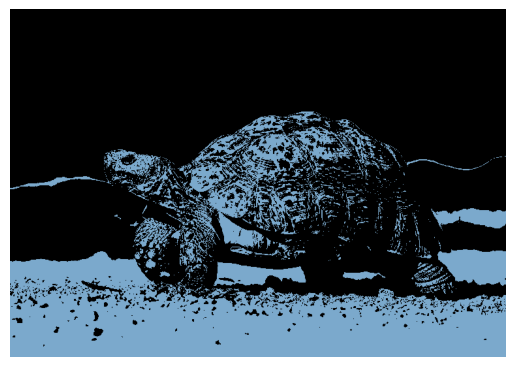

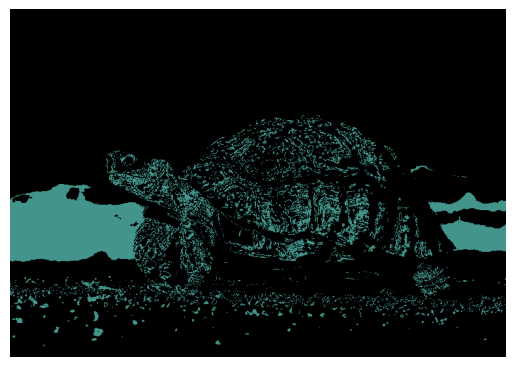

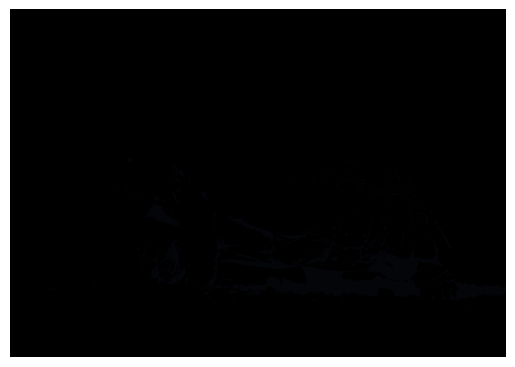

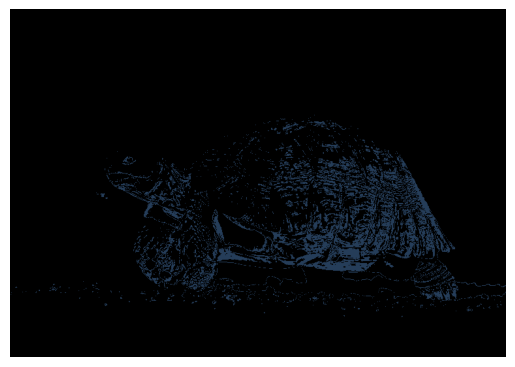

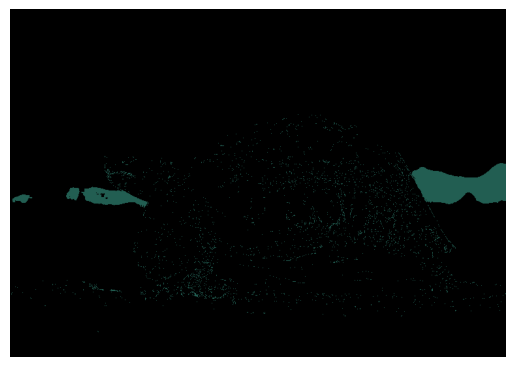

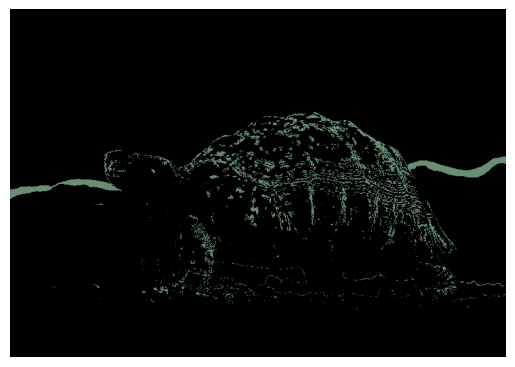

In [82]:
for label in np.unique(labeled):
    result=np.zeros(X.shape,dtype=np.uint8)
    result[labeled==label,:]=cluster_int8[label,:]  
    plt.imshow(cv.cvtColor(result.reshape(img.shape), cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.savefig("meanshift_label_0" +str(label) + ".png")
    plt.show()
    

## with blur effect

In [83]:
img_blured = cv.medianBlur(img, 7)


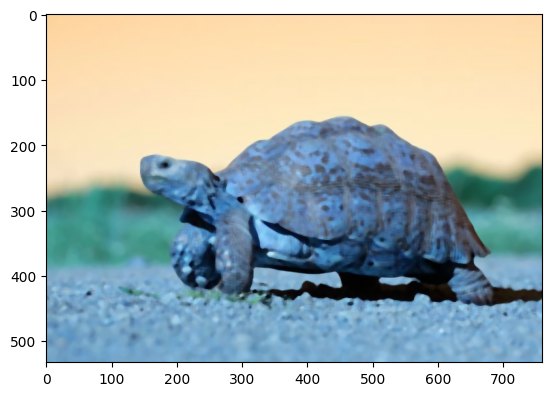

In [84]:
plt.imshow(cv.cvtColor(img_blured, cv.COLOR_BGR2RGB))

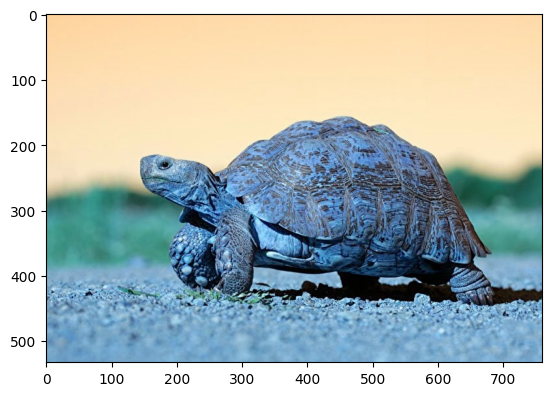

In [85]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))